In [1]:
%load_ext edx_jupyter

In [2]:
x = %vertica SELECT 'Connected to Vertica!'
print(x.loc[0][0])

Connected to Vertica!


In [3]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import chi2_contingency

In [4]:
%matplotlib inline

In [5]:
intervention_date = datetime.date(2017,6,5)
window_end_date = intervention_date + datetime.timedelta(days=28)
print(window_end_date)

2017-07-03


In [6]:
%%vertica (intervention_date=intervention_date, window_end_date=window_end_date) -> return_rate
SELECT
    ee.user_id,
    ee.course_id,
    ee.group_name,
    CASE WHEN MIN(act.date) IS NOT NULL THEN 1 ELSE 0 END AS has_returned
FROM
    ret.email_experiment ee
LEFT JOIN
        public.all_user_engagement as act
     ON act.user_id = ee.user_id
    AND act.course_id = ee.course_id
    AND act.date BETWEEN :intervention_date AND :window_end_date
    AND act.is_engaged = 1
WHERE
    ee.experiment_id = 0
GROUP BY
    1, 2, 3

In [7]:
control_group = return_rate[return_rate.group_name == 'Control'].copy()
treatment_group = return_rate[return_rate.group_name == 'Sent Email'].copy()

In [8]:
random_seed = 9837598
trials_per_sample = 100
iterations = 200
significance_level = 0.10

In [9]:
def probability_of_return(df):
    result = df.groupby('has_returned').user_id.count()
    if len(result) > 1:
        return result[1] / float(result[0])
    else:
        return 0

In [10]:
def get_distribution(group):
    sampled_group = group.copy()
    probabilities_of_return = []
    for i in range(iterations):
        sample = sampled_group.sample(trials_per_sample, replace=False)
        probabilities_of_return.append(probability_of_return(sample))
    return pd.Series(probabilities_of_return)

In [11]:
treatment_group_dist = get_distribution(treatment_group)
control_group_dist = get_distribution(control_group)

In [12]:
def plot_distribution_with_normal_fit(data, label='', color='g'):
    mu, std = norm.fit(data)
    print('{0} mean={1} stddev={2}'.format(label, mu, std))

    plt.hist(data, bins=15, normed=True, alpha=0.3, color=color, label=label)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, color=color)

Treatment mean=0.07324400208934914 stddev=0.028340671295331372
Control mean=0.05453881409827614 stddev=0.027137767229420743


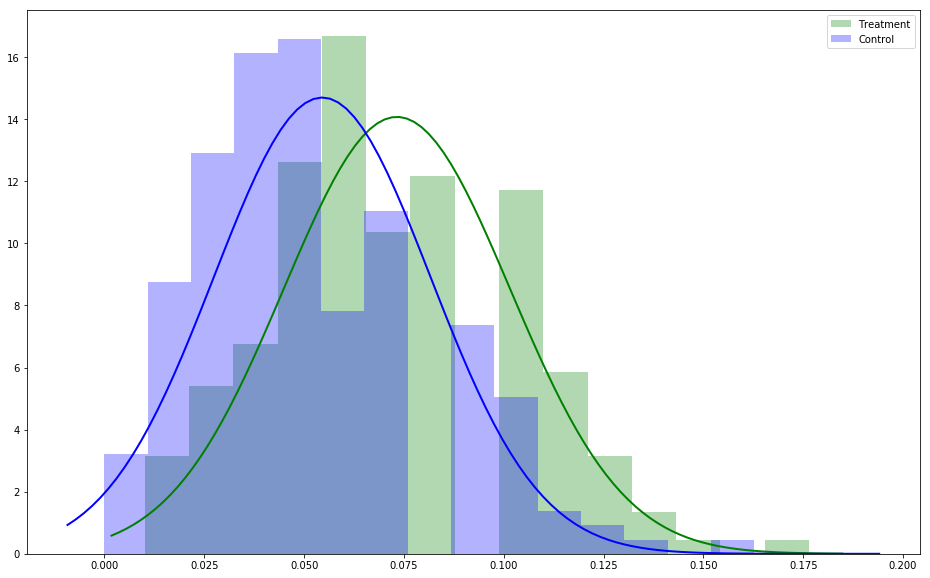

In [13]:
fig = plt.figure(figsize=(16, 10))
plot_distribution_with_normal_fit(treatment_group_dist, label='Treatment')
plot_distribution_with_normal_fit(control_group_dist, label='Control', color='b')
plt.legend()

In [22]:
def summarize(df):
    results = df.groupby('has_returned').user_id.count()
    s = {}
    s['cnt_success'] = results[1]
    s['cnt_failures'] = results[0]
    s['N'] = s['cnt_success'] + s['cnt_failures']
    assert(s['N'] == len(df))
    s['p_return'] = s['cnt_success'] / float(s['N'])
    return s

def is_statisticially_significant(treatment_group, control_group, sig_level=significance_level, two_sided=True):
    stats = {
        'treatment': summarize(treatment_group),
        'control': summarize(control_group)
    }
    
    if two_sided:
        sig_level = sig_level / 2
    z_value = norm.ppf(1 - sig_level)

    p_pool = (stats['treatment']['cnt_success'] + stats['control']['cnt_success']) / float(stats['treatment']['N'] + stats['control']['N'])
    pool_standard_error = math.sqrt(p_pool * (1 - p_pool) * ((1/stats['treatment']['N']) + (1/stats['control']['N'])))
    
    d_hat = stats['treatment']['p_return'] - stats['control']['p_return']
    return (d_hat < (-z_value * pool_standard_error) or d_hat > (z_value * pool_standard_error), stats)

In [23]:
is_sig, stats = is_statisticially_significant(treatment_group, control_group)

In [24]:
import pprint
pprint.pprint(stats)

{'control': {'N': 74829,
             'cnt_failures': 70718,
             'cnt_success': 4111,
             'p_return': 0.054938593326116877},
 'treatment': {'N': 74963,
               'cnt_failures': 69666,
               'cnt_success': 5297,
               'p_return': 0.070661526353000811}}


In [25]:
print(is_sig)

True


In [26]:
contingency_table = np.array([
    [stats['treatment']['cnt_failures'], stats['treatment']['cnt_success']],
    [stats['control']['cnt_failures'], stats['control']['cnt_success']]
])

In [27]:
g, p, dof, expected = chi2_contingency(contingency_table)

In [28]:
if p < significance_level:
    print('Significant!')
else:
    print('Not significant...')

Significant!


In [29]:
effect_size = (stats['treatment']['p_return'] - stats['control']['p_return']) / stats['control']['p_return']
effect_size * 100

28.619103757448261